### Демонстрационный файл

> Программа выполняет полный анализ текстового корпуса:
> извлечение признаков, фильтрация текста, обработка слов,
> составление вектора. Полученные данные сохраняются в БД.
> Далее, выполняется классификация выбранного корпуса текстов
> на основе полученных входных и выходных векторов.
> Все параметры для настройки системы анализа текстовой 
> информации задаются файлом param.json


**Подключение внешних библиотек:**

In [1]:
import sys
sys.path.append('..')
from DbInteraction import DbInteraction
from Param import Param
from OpenTexts import OpenTexts
from CorpusParser import CorpusParser
from Dictionary import Dictionary
from Vectorizer import Vectorizer
from CorpusAnalyzer import CorpusAnalyzer
from utility import ProgressBar
from utility import Table
import time
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
print("Готово!")

Готово!


**Инициализация работы с БД:**

In [2]:
t = time.localtime()
compilationTime = "{0}.{1}.{2} {3}:{4}".format(t.tm_year, t.tm_mon, 
                                               t.tm_mday, t.tm_hour, 
                                               t.tm_min)

p = Param('../param.json') #инициализация класса с параметрами работы
p.printParam()
db = DbInteraction() #иниц. класса для работы с БД
db.initFullAnalysis(p.readDBCorpusPath()) #иниц. класса для работы с БД
# отправка в него пути к БД
corpusID = db.getCorpusID() #сохранение актуального ID, который
# является индексом строки в БД
print('Добавление информации в базу данных...')
db.updateCorpus('name', p.readName(), corpusID) #добавление начальной инфо
# рмации о корпусе. данные считываются с параметров и отправляются
db.updateCorpus('language', p.readLanguage(), corpusID) #
db.updateCorpus('stemType', p.readStemType(), corpusID) #
db.updateCorpus('stopWordsType', p.readStopWordsType(), corpusID) #
db.updateCorpus('metric', p.readMetric(), corpusID) #
db.updateCorpus('compilationTime', compilationTime, corpusID)
db.updateCorpus('source', p.readSource(), corpusID)


db.addInfo()
db.updateInfo('name', p.readName(), 1) #добавление начальной инфо
# рмации о корпусе. данные считываются с параметров и отправляются
db.updateInfo('language', p.readLanguage(), 1)
db.updateInfo('stemType', p.readStemType(), 1)
db.updateInfo('stopWordsType', p.readStopWordsType(), 1)
db.updateInfo('metric', p.readMetric(), 1)
db.updateInfo('corpus_ID', corpusID, 1)
db.updateInfo('compilationTime', compilationTime, 1)
db.updateInfo('source', p.readSource(), 1)
print("Готово!")

Полный список выбранных параметров программы:
{
    "name": "brownTest",
    "language": "eng",
    "source": "brown",
    "stemType": "stem",
    "stopWordsType": "default",
    "metric": "tf",
    "maxFeatures": 1000,
    "dbCorpusPath": "/home/evgeniy/python_nlp/dataBase/myCorpus2.db",
    "docCorpusPath": "/home/evgeniy/python_nlp/corpuses/myCorpus/topicsSmall",
    "trainPercentage": 70, 
    "saveDictionary": true,
    "pathToDBForReport": "/home/evgeniy/python_nlp/dataBase/7.db"
}
Добавление информации в базу данных...
Готово!


**Получение списка используемых текстов и отправка имени текста, 
имени темы и исходного текста в БД:**

In [3]:
analyzer = CorpusAnalyzer() # аналайзер дополняет БД оставшимися данными

op = OpenTexts(p.readSource(), p.readDocCorpusPath()) # иниц. класса для работы с исходными
# текстами
print("Открытие исходных текстов...")
while(op.hasNext()): # проверка на наличие следующего текста
    tempData = op.getNext() # извлечение базовой информации из 
    # файла, сохранение в словаре
    lastID = db.addTexts() # добавление новой строки в бд для 
    # информации по текстам и возврат её номера
    db.updateTexts('name', tempData['name'], lastID) # обновление 
    # данных в соответствующей строке
    db.updateTexts('topicName', tempData['topicName'], lastID) #
    db.updateTexts('baseText', tempData['baseText'], lastID) #
    
    analyzer.addTopicName(tempData['topicName'])
    db.updateTexts('topicNum', analyzer.getTopicNum(tempData['topicName']), lastID)
print("Готово!")
    # <- аналайзер необходим, для получения списка используемых топиков.
    # он запоминает имена топиков, присваивает им имена и, в данном месте,
    # отправляет имена в БД, для отчётности и для дальнейшего формирования
    # выходного вектора.

Открытие исходных текстов...
Открыто: 500Готово!


**Обновление таблицы БД со списком тем для отчётности:**

In [4]:
print('\nОбновление списка тем...')
for name, val, i in zip(analyzer.getList().keys(), 
                     analyzer.getList().values(),
                     range(analyzer.getNumOfTopics())):
    db.addTopicList() # добавление новой строки в бд для списка топиков
    db.updateTopicList('name', name, i+1)
    db.updateTopicList('topicNum', val, i+1)
    db.updateTopicList('numOfTexts', analyzer.getTopicCount(name), i+1)
    # <- обновление информации в таблице со списком топиков
    # общая информация, для отчетности
print("Готово!")


Обновление списка тем...
Готово!


**Фильтрация исходных текстов. Отправка обработанных текстов в БД:**

In [5]:
print("Выполняется парсинг текстов...")
parser = CorpusParser(language = p.readLanguage(), 
                      stemType = p.readStemType(),
                      stopWordsType = p.readStopWordsType())
pb = ProgressBar(maxValue=db.getTextsSize(),
              suffix='обработано')
for i in range(db.getTextsSize()):
    tempText = db.getTextsData('baseText', i+1)[0][0]
    tempText = parser.parsing(tempText)
    db.updateTexts('formattedText', tempText, i+1)
    pb.inc()
print("Готово!")
# <- выполняется полный проход по всем сырым текстам в бд
# забираются сырые тексты, отправляются на очистку
# возвращаются тексты после фильтрации и отправляются в БД обратно

Выполняется парсинг текстов...
[========================================] 100.0% ...обработано

Готово!


**Фомирование общего словаря для всех текстов и отправка
словаря в БД:**

In [6]:
print('Сохранение локальных словарей в базе данных...')
d = Dictionary(p.readMetric())
pb.new(maxValue=db.getTextsSize(), suffix='сохранено')
for i in range(db.getTextsSize()):
    d.addData(db.getTextsData('formattedText', i+1)[0][0])
    tempDict = d.getLastDictionary()
    tempStr = json.dumps(tempDict)
    tempStr = tempStr.replace('"', '""') 
    db.updateTexts('localDictionary', tempStr, i+1)
    # <- добавление в БД локальных словарей в виде json строки
    pb.inc()
print("Готово!")

Сохранение локальных словарей в базе данных...
[========================================] 100.0% ...сохранено

Готово!


**Вычисление дополнительных параметров словаря для векторизации и уменьшения пространства признаков**

In [7]:
print('Вычисление дополнительных параметров словаря...')
d.idfGlobalCalc()
# <- вычисление параметра IDF для глобального словаря

v = Vectorizer(p.readMetric())
v.addGlobDict(d.getGlobalDictionary())
# <- инициализация векторизатора и отправка в него глобального словаря

if isinstance(p.readMaxFeatures(), int):
    d.reduceFeatures(p.readMaxFeatures())
    if (p.readMetric() == 'tfidf'):
        v.addIdfDict(d.getTfidfDict())
# <- если есть ограничение на количество признаков, то
# выполнить операцию уменьшения пространства признаков
print("Готово!")

Вычисление дополнительных параметров словаря...
Готово!


**Обновление общей информации, для отчётности:**

In [8]:
if p.saveDictionary == True:
    print('Добавление глобального словаря в базу данных...')
    pb.new(maxValue = d.getGlobalSize(),
          suffix = 'добавлено')
    tempDict = d.getGlobalDictionary()
    idfTable = d.getAdditionalTable()
    for key, val in tempDict.items():
        lastID = db.addDictionary()
        db.updateDictionary('word', key, lastID)
        db.updateDictionary('value', val, lastID)
        db.updateDictionary('docCount', idfTable.getVal(key, "count"), lastID)
        pb.inc()
        # <- добавление глобального словаря в бд, целиком
else:
    idfTable = d.getAdditionalTable()
  
inputSize = d.getGlobalSize()
outputSize = db.getTopicListSize()
corpusSize = db.getTextsSize()

db.updateCorpus('numOfTopics', outputSize, corpusID)
db.updateInfo('numOfTopics', outputSize, 1)
db.updateCorpus('numOfTexts', corpusSize, corpusID)
db.updateInfo('numOfTexts', corpusSize, 1)
db.updateCorpus('dictionarySize', inputSize, corpusID)
db.updateInfo('dictionarySize', inputSize, 1)
print("Готово!")

Готово!


**Фомирование входных и выходных векторов к каждому тексту,
отправка их в БД:**

In [9]:
pb.new(maxValue=corpusSize,
      suffix="обработано")
for i in range(db.getTextsSize()):
    tempStr = db.getTextsData('localDictionary', i+1)[0][0]
    tempDict = json.loads(tempStr)
    tempArray = v.getVecFromDict(tempDict)
    tempStr = json.dumps(tempArray)
    db.updateTexts('inputVector', tempStr, i+1)
    # <- инициализация векторизатора, отправка глобального словаря в 
    # него, извлечение из бд локального словаря, преобразование 
    # его из json-строки в стандартный словарь отправка словаря 
    # в векторизатор, получение массива преобразование массива 
    # в json-строку и отправка обратно в бд
    topicNum = db.getTextsData('topicNum', i+1)[0][0]
    db.updateTexts('outputVector', 
                   json.dumps(v.numToOutputVec(topicNum, outputSize)),
                   i+1)
    pb.inc()
    # <- извлечение номера топика для формирования входного вектора
    # и отправки этого вектора в БД
print("Готово!")

[========================================] 100.0% ...обработано

Готово!


**Настройка объекта для последовательного извлечения 
входных и выходных данных:**

In [10]:
print("Извлечение векторов из базы данных...")
c = db.getConnectionData()
ds = tf.data.Dataset.from_generator(
    db.generator(corpusSize, db.getDataCorpusName(), 'inputVector', 'outputVector'),
    output_types=(tf.float64, tf.float64),
    output_shapes=(tf.TensorShape((inputSize, )), tf.TensorShape((outputSize, ))))
    # <- использование генератора, который содержит весь набор данных и 
    # извлекает их, по необходимости
print("Готово!")

Извлечение векторов из базы данных...
Готово!


**Разделение данных на обучающую и тестовую:**

In [11]:
print("Формирование данных для обучения...")
ds = ds.shuffle(buffer_size=corpusSize,
                reshuffle_each_iteration=True)
trainSize = int(corpusSize*p.getTrainPercentage()/100)
ds_train = ds.take(trainSize)
ds_val = ds.skip(trainSize)
ds = None
ds_train = ds_train.batch(30)
ds_val = ds_val.batch(30)
print("Готово!")

Формирование данных для обучения...
Готово!


**Формирование и подготовка нейронной сети:**

In [12]:
print("Создание нейросетевой модели...")
model = tf.keras.Sequential()

model.add(layers.Dense(inputSize, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(outputSize, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print("Готово!")

Создание нейросетевой модели...
Готово!


**Начало процесса обучения сети:**

In [13]:
print("Начало процесса обучения сети...")
history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val)
print("Готово!")

Начало процесса обучения сети...
Epoch 1/20
12/12 [==============================] - 1s 62ms/step - loss: 2.5648 - categorical_accuracy: 0.1829 - val_loss: 2.1839 - val_categorical_accuracy: 0.2000
Epoch 2/20
12/12 [==============================] - 1s 45ms/step - loss: 2.0810 - categorical_accuracy: 0.2829 - val_loss: 1.8465 - val_categorical_accuracy: 0.3400
Epoch 3/20
12/12 [==============================] - 1s 46ms/step - loss: 1.7615 - categorical_accuracy: 0.3771 - val_loss: 1.7145 - val_categorical_accuracy: 0.3400
Epoch 20/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0774 - categorical_accuracy: 0.9857 - val_loss: 0.0198 - val_categorical_accuracy: 1.0000
Готово!


**Построение графиков для отчета:**

Подготовка графиков...


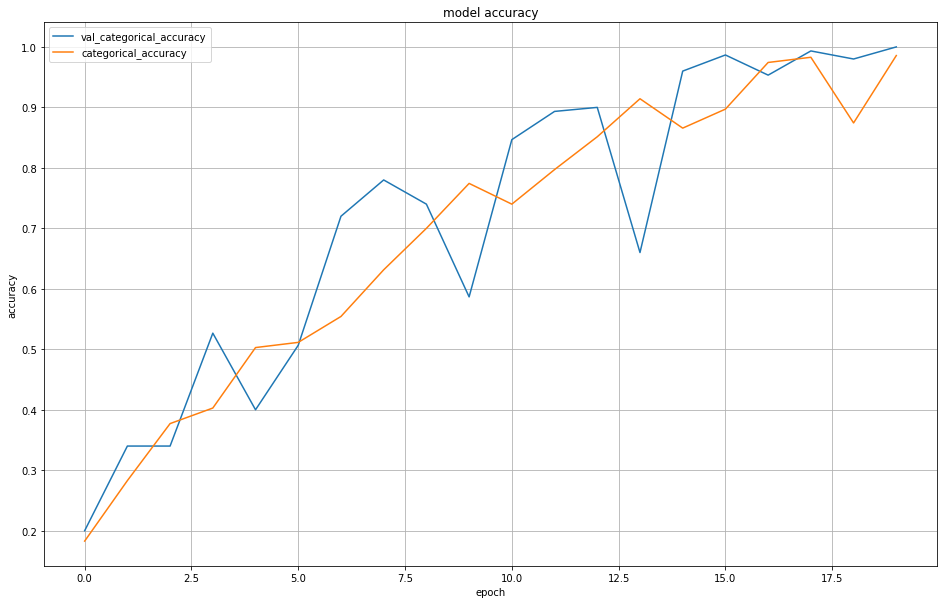

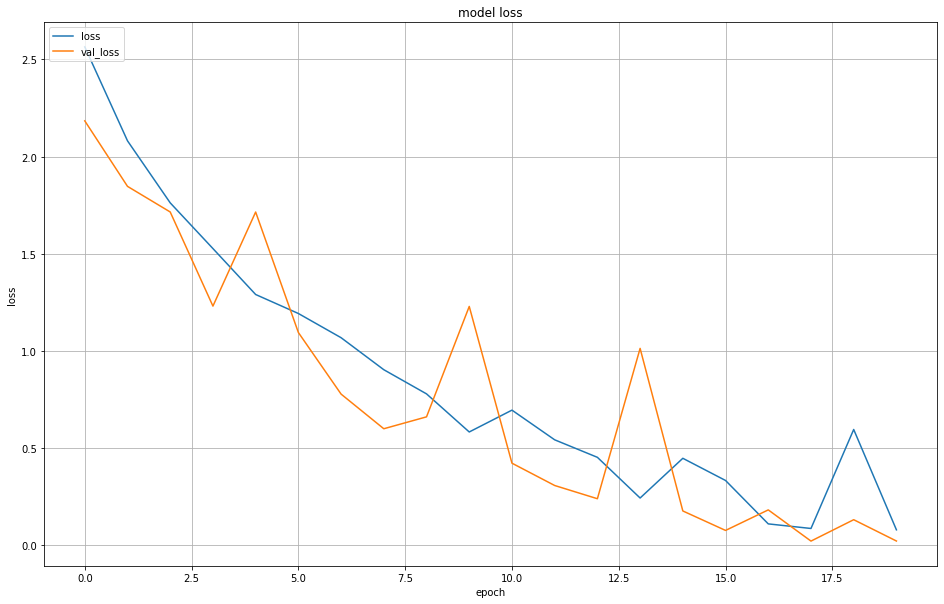

Готово!


In [14]:
print("Подготовка графиков...")
plt.figure(figsize=(16, 10))
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_categorical_accuracy', 'categorical_accuracy'], loc='upper left')
plt.grid(True)
plt.show()

#summarize history for loss
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.grid(True)
plt.show()
print("Готово!")